In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter,MaxNLocator
from matplotlib import font_manager

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser

from langgraph.graph import END, StateGraph

from typing_extensions import TypedDict
from typing import List
from typing import Literal

from utilities.colleges import CollegesData
from utilities.knowledgebase import TXTKnowledgeBase
from utilities import languages
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = 'college-information-llm'

In [2]:
SEARCH_DOCS_NUM=4
SEARCH_COLLEGES_NUM=2
lang_dict=languages.cn_dict

kb=TXTKnowledgeBase(txt_source_folder_path='lxbd')
vector=kb.return_retriever_from_persistant_vector_db()

documents_retriever = vector.as_retriever(search_kwargs={'k':SEARCH_DOCS_NUM})

In [3]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [4]:
class College_Info(BaseModel):
    cname:str=Field(description='学校中文全名')
    ename:str=Field(description='学校英文全名')
    postid:str=Field(description='学校的postid')
    unitid:str=Field(description='学校的unitid')
    data_type:str=Field(description="数据种类，可以是'排名'、'录取率'、'申请录取人数'、'成绩要求'、'学生组成'、'学生人数'、'学费'、'毕业率'、'犯罪率'这几种中的一种，如果留学生相关则输出'学生人数'，如果涉及住宿费则输出'学费'，如果涉及学生保有率则输出'毕业率'，如果不在以上这些类型中请输出'不是数据'")
    

In [5]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
        college_name: College name
        data_type: College data type
        plot_type: College data plot type, can be line plot, bar plot, scatter plot or tree plot
    """

    question: str
    generation: str
    documents: List[str]
    college_info:College_Info
    data_type:str
    plot_type:str
    data:pd.DataFrame
    chat_history:list


In [6]:
def retrieve(state):
#print("---RETRIEVE---")
    vector=TXTKnowledgeBase(txt_source_folder_path='lxbd').return_retriever_from_persistant_vector_db()
    vector_lxsq=TXTKnowledgeBase(txt_source_folder_path='lxsq').return_retriever_from_persistant_vector_db()
    vector_emergency=TXTKnowledgeBase(txt_source_folder_path='emergency').return_retriever_from_persistant_vector_db()
    vector.merge_from(vector_lxsq)
    vector.merge_from(vector_emergency)
    documents_retriever = vector.as_retriever(search_kwargs={'k':SEARCH_DOCS_NUM})
    question=state["question"]
    documents=documents_retriever.invoke(question)
    return {"documents":documents,"question":question,"chat_history":state['chat_history']}


In [7]:
def generate(state):
    #print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    # Prompt
    prompt = ChatPromptTemplate.from_messages([
        ('system',lang_dict['prompt_document']),
        ('human',"{question}")
    ])

    rag_chain = prompt | llm | StrOutputParser()
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question,'chat_history':state['chat_history']})

    return {"documents": documents, "question": question, "generation": generation}


In [8]:
def route_question(state):
    #print("---ROUTE QUESTION---")
    # Data model
    class RouteQuery(BaseModel):
        """基于用户的查询词条选择最相关的资料来源"""
    
        datasource: Literal["vectorstore","database"] = Field(
            ...,
            description="基于用户的问题选择vectrostore或者database.",
        )

    structured_llm_router = llm.with_structured_output(RouteQuery)
    
    # Prompt
    system = """你是一位选择路径的专家，你需要基于用户的提问选择是使用vectorstore还是database.
    vectorstore包含了关于总体的在美国留学相关的资料，比如美国大学排名，美国留学申请，美国转学等等.
    database包含了特定一所大学的相关数据，比如这所大学的排名、录取率、申请人数、录取人数、成绩要求、学生组成、学生人数、学费、住宿费、犯罪率等等.
    如果用户的问题是美国留学相关但是不针对某一所大学的问题，或者用户需要知道两所或两所以上大学的相关信息，请选择vectorstore，如果是针对特定一所美国大学且只能是一所大学的问题，请选择database."""
    route_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{question}"),
        ]
    )
    
    question_router = route_prompt | structured_llm_router
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "vectorstore":
        #print("---ROUTE QUESTION TO RAG---")
        return "to_retrieve"
    elif source.datasource=="database":
        #print("---ROUTE QUESTION TO DATABASE----")
        return "to_database"


In [9]:
def get_college_info(state):
    #print("---COLLEGE NAME---")
    
    college_data=CollegesData()
    college_vector=college_data.return_colleges_vector_from_db()
    college_retriever=college_vector.as_retriever(search_kwargs={'k':SEARCH_COLLEGES_NUM})
    prompt = ChatPromptTemplate.from_messages([
        ('system',"你是一位了解美国高等院校的专家，你需要根据用户的问题提取出一所美国高等院校的全名，包括中文名和英文名，输出格式为'中文全名（英文全名）'"),
        ('human',"{question}")
    ])
    college_name_chain=prompt | llm | StrOutputParser()
    
    college_info_structured_output=llm.with_structured_output(College_Info)
    prompt = ChatPromptTemplate.from_messages([
        ("system", "基于下面学校信息内容及用户的问题，按照格式输出学校信息回答"),
        ("human", "用户问题如下：{question}，学校信息内容如下：{context}"),
    ])
    college_info_chain=prompt | college_info_structured_output

    question=state["question"]
    college_name=college_name_chain.invoke({'question':question})
    college_info=college_info_chain.invoke({
        'question':question,
        'context':college_retriever.invoke(college_name)
    })
    return {'college_info':college_info,'question':question}


In [10]:
def college_data_plot(state):
    question=state['question']
    college_info=state['college_info']
    dataURLs={
        "rank_adm":"https://www.forwardpathway.com/d3v7/dataphp/school_database/ranking_admin_20231213.php?name=",
        "world_rank":"https://www.forwardpathway.com/d3v7/dataphp/chatbot/world_ranks4_20240605.php?name=",
        "score":"https://www.forwardpathway.com/d3v7/dataphp/school_database/score10_20231213.php?name=",
        "students":"https://www.forwardpathway.com/d3v7/dataphp/school_database/student_comp_20240118.php?name=",
        "students_number":"https://www.forwardpathway.com/d3v7/dataphp/school_database/international_students_20240118.php?name=",
        "info":"https://www.forwardpathway.com/d3v7/dataphp/school_database/school_information_20240118.php?name=",
        "crime":"https://www.forwardpathway.com/d3v7/dataphp/school_database/crime_yearly_20240324.php?name="
    }
    if college_info.data_type=='排名':
        college_df=pd.read_json(dataURLs["rank_adm"]+str(college_info.postid))
        data=pd.read_json(dataURLs["world_rank"]+str(college_info.postid))
        #college_df['year']=college_df['year'].astype(str)
        college_df=college_df[['year','rank']].rename(columns={'year':'年','rank':'USNews排名'})
        college_df.loc[len(college_df)]=pd.Series({'年':college_df['年'].to_list()[-1]+1}).astype('Int64')
        college_df.set_index('年',inplace=True)
        for index,row in data.iterrows():
            college_df[row['type']+'世界大学排名']=pd.DataFrame(row['data']).fillna(0).rename(columns={'year':'年','rank':(row['type']+'世界大学排名')}).set_index('年')[(row['type']+'世界大学排名')]
            college_df[row['type']+'世界大学排名']=college_df[row['type']+'世界大学排名'].astype('Int64')
        college_df.dropna(how='all',inplace=True)
    elif college_info.data_type=='录取率':
        college_df=pd.read_json(dataURLs["rank_adm"]+str(college_info.postid))
        college_df['year']=college_df['year'].astype(str)
        college_df=college_df[['year','rate','rate2']].rename(columns={'year':'年','rate':'男生录取率','rate2':'女生录取率'})
        college_df.set_index('年',inplace=True)
    elif college_info.data_type=='申请录取人数':
        college_df=pd.read_json(dataURLs["rank_adm"]+str(college_info.postid))
        college_df['year']=college_df['year'].astype(str)
        college_df=college_df[['year','enroll','defer','deny']].rename(columns={'year':'年','enroll':'录取且入学人数','defer':'录取但未入学人数','deny':'拒绝人数'})
        college_df.set_index('年',inplace=True)
    elif college_info.data_type=='成绩要求':
        data=pd.read_json(dataURLs["score"]+str(college_info.postid))
        college_df=pd.DataFrame(data.columns,columns=['year'])
        testArray={'SATR':'SAT阅读','SATM':'SAT数学','ACTC':'ACT综合','ACTE':'ACT英语','ACTM':'ACT数学'}
        for test in testArray.keys():
            college_df[test+'25']=None
            college_df[test+'75']=None
        college_df.set_index('year',inplace=True)
        def temp_fuc(x,item_name,item_per):
            for item in x:
                if item['name']==item_name:
                    return item[item_per]
        for test,test_name in testArray.items():
            college_df[test+'25']=data.T['score'].apply(temp_fuc,args=(test,'start'))
            college_df[test+'75']=data.T['score'].apply(temp_fuc,args=(test,'end'))
            college_df.rename(columns={(test+'25'):test_name+'25%'},inplace=True)
            college_df.rename(columns={(test+'75'):test_name+'75%'},inplace=True)
    elif college_info.data_type=='学生组成':
        data=pd.read_json(dataURLs["students"]+str(college_info.postid))
        df1=data[['name','value']].rename(columns={'name':'学生类别','value':'数量'}).replace({
            'uf':lang_dict['data_under_fresh'],
            'uj':lang_dict['data_under_junior'],
            'ut':lang_dict['data_under_trans'],
            'gr':lang_dict['data_under_grad'],
            'nd':lang_dict['data_no_degree']
        })
        tempArray={
            'wh':lang_dict['data_race_white'],
            'as':lang_dict['data_race_asian'],
            'la':lang_dict['data_race_latino'],
            'pa':lang_dict['data_race_pacific'],
            'af':lang_dict['data_race_africa'],
            'nr':lang_dict['data_race_nr'],}
        df2=pd.DataFrame(columns=['学生种族','数量'])
        def temp_fuc(row,k):
            for subrow in row:
                if subrow['name']==k:
                    return subrow['value']
        for key,value in tempArray.items():
            temp=pd.DataFrame({'学生种族':[value],'数量':[data['subs'].apply(temp_fuc,args=([key])).sum()]})
            df2=pd.concat([df2,temp],ignore_index=True)
        college_df={str(int(data['year'][0]))+'年学生组成':[df1,df2]}
    elif college_info.data_type=='学生人数':
        college_df=pd.read_json(dataURLs["students_number"]+str(college_info.postid))
        college_df=college_df.rename(columns={'undertotal':'本科生人数','under':'本科留学生人数','underper':'本科留学生占比','gradtotal':'研究生人数','grad':'研究生留学生人数','gradper':'研究生留学生占比'})
        college_df['year']=college_df['year'].apply(lambda x:x[:-1])
    elif college_info.data_type=='学费':
        data=pd.read_json(dataURLs["info"]+str(college_info.postid))
        college_df=pd.DataFrame()
        tuition_array={'year':'year','tuition_in_under':'州内本科生学费','tuition_out_under':'外州本科生学费','tuition_in_grad':'州内研究生学费','tuition_out_grad':'外州研究生学费','room':'住宿费'}
        for key,value in tuition_array.items():
            college_df[value]=data['tuition'].apply(lambda x: x[key])
        college_df['year']=college_df['year'].astype(str)
    elif college_info.data_type=='毕业率':
        data=pd.read_json(dataURLs["info"]+str(college_info.postid))
        college_df=pd.DataFrame()
        college_df['year']=data['graduation'].apply(lambda x:x['year'])
        college_df['毕业率']=data['graduation'].apply(lambda x:x['graduation_100_under'])
        college_df['学生保有率']=data['retention'].apply(lambda x:x['retention_under'])
    elif college_info.data_type=='犯罪率':
        college_df=pd.read_json(dataURLs["crime"]+str(college_info.postid))
        college_df=college_df[['year','avg1000']].rename(columns={'avg1000':'每千人学生记过、犯罪率'})
    return {'college_info':college_info,'question':question,'data':college_df}

In [11]:
def plot_college_data(df,data_type):
    with st.chat_message("assistant",avatar=avatars['assistant']):
        fig,ax=plt.subplots(figsize=(9,4))
        if data_type=="排名":
            fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(9,8))
            axes[0].text(0.5, 0.5, 'Forward Pathway', transform=axes[0].transAxes,fontsize=50, color='gray', alpha=0.02,ha='center', va='center', rotation=20)
            axes[0].plot(df['USNews排名'],'o-')
            axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))
            axes[0].invert_yaxis()
            axes[0].set_ylabel(lang_dict['data_ranking'])
            axes[1].text(0.5, 0.5, 'Forward Pathway', transform=axes[1].transAxes,fontsize=50, color='gray', alpha=0.02,ha='center', va='center', rotation=20)
            world_ranks=['QS', 'USNews', 'THE',  'ARWU']
            for world_rank in world_ranks:
                axes[1].plot(df[world_rank+'世界大学排名'],'o-',label=world_rank+' '+lang_dict['data_world_ranking'])
            axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))
            axes[1].invert_yaxis()
            axes[1].set_ylabel(lang_dict['data_world_ranking'])
            axes[1].legend()
        elif data_type=="录取率":
            ax.text(0.5, 0.5, 'Forward Pathway', transform=ax.transAxes,fontsize=50, color='gray', alpha=0.02,ha='center', va='center', rotation=20)
            ax.plot(df.index,df['男生录取率'],'bo-',label=lang_dict['data_men_adm'])
            ax.plot(df.index,df['女生录取率'],'ro-',label=lang_dict['data_women_adm'])
            ax.set_ylabel(lang_dict['data_admission_rate'])
            ax.yaxis.set_major_formatter(PercentFormatter(1))
            plt.legend()
        elif data_type=="申请录取人数":
            ax.text(0.5, 0.5, 'Forward Pathway', transform=ax.transAxes,fontsize=50, color='gray', alpha=0.02,ha='center', va='center', rotation=20)
            lns1=ax.plot(df.index,df['录取且入学人数'],'bo-',label=lang_dict['data_enroll_num'])
            lns2=ax.plot(df.index,df['录取但未入学人数'],'ro-',label=lang_dict['data_defer_num'])
            ax_twin=ax.twinx()
            lns3=ax_twin.plot(df.index,df['拒绝人数'],'go-',label=lang_dict['data_reject_num'])
            ax.set_ylabel(lang_dict['data_enrollment'])
            ax_twin.set_ylabel(lang_dict['data_reject_num'])
            lns = lns1+lns2+lns3
            labs = [l.get_label() for l in lns]
            plt.legend(lns, labs,loc=0)
        elif data_type=="成绩要求":
            fig,axes=plt.subplots(nrows=3,ncols=2,figsize=(9,10))
            if(df['SAT阅读25%'].isnull().sum()<df['SAT阅读25%'].shape[0]):
                axes[0,0].fill_between(df.index,df['SAT阅读25%'],df['SAT阅读75%'])
            axes[0,0].set_ylabel(lang_dict['data_sat_reading'])
            if(df['SAT数学25%'].isnull().sum()<df['SAT数学25%'].shape[0]):
                axes[0,1].fill_between(df.index,df['SAT数学25%'],df['SAT数学75%'])
            axes[0,1].set_ylabel(lang_dict['data_sat_math'])
            if(df['ACT英语25%'].isnull().sum()<df['ACT英语25%'].shape[0]):
                axes[1,0].fill_between(df.index,df['ACT英语25%'].dropna(),df['ACT英语75%'].dropna(),color='coral')
            axes[1,0].set_ylabel(lang_dict['data_act_english'])
            if(df['ACT数学25%'].isnull().sum()<df['ACT数学25%'].shape[0]):    
                axes[1,1].fill_between(df.index,df['ACT数学25%'].dropna(),df['ACT数学75%'].dropna(),color='coral')
            axes[1,1].set_ylabel(lang_dict['data_act_math'])
            if(df['ACT综合25%'].isnull().sum()<df['ACT综合25%'].shape[0]):
                axes[2,0].fill_between(df.index,df['ACT综合25%'].dropna(),df['ACT综合75%'].dropna(),color='coral')
            axes[2,0].set_ylabel(lang_dict['data_act_comp'])
            axes[2,1].axis('off')
        elif data_type=='学生组成':
            df=next(iter(df.values()))
            fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(9,6))
            def my_autopct(pct):
                return ('%.1f%%' % pct) if pct > 5 else ''
            explode=((df[0]['学生类别']==lang_dict['data_under_fresh'])/6).to_list()
            axes[0].pie(df[0]['数量'],labels=df[0]['学生类别'],autopct=my_autopct,explode=explode)
            explode=((df[1]['学生种族']==lang_dict['data_race_nr'])/6).to_list()
            axes[1].pie(df[1]['数量'],labels=df[1]['学生种族'],explode=explode,autopct=my_autopct)
        elif data_type=='学生人数':
            fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(9,8))
            axes[0].text(0.5, 0.5, 'Forward Pathway', transform=axes[0].transAxes,fontsize=50, color='gray', alpha=0.02,ha='center', va='center', rotation=20)
            axes[0].plot(df['year'],df['本科生人数'],'o-',label=lang_dict['data_under_students_num'])
            axes[0].plot(df['year'],df['研究生人数'],'o-',label=lang_dict['data_grad_students_num'])
            axes[0].set_ylabel(lang_dict['data_students_num'])
            axes[0].tick_params(axis='x',rotation=30)
            axes[0].legend()
            axes[1].text(0.5, 0.5, 'Forward Pathway', transform=axes[1].transAxes,fontsize=50, color='gray', alpha=0.02,ha='center', va='center', rotation=20)
            axes[1].plot(df['year'],df['本科留学生人数'],'o-',label=lang_dict['data_under_nr_num'])
            axes[1].plot(df['year'],df['研究生留学生人数'],'o-',label=lang_dict['data_grad_nr_num'])
            axes[1].set_ylabel(lang_dict['data_international_students_number'])
            axes[1].tick_params(axis='x',rotation=30)
            axes[1].legend()
            plt.tight_layout()
        elif data_type=='学费':
            fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(9,6))
            axes[0,0].text(0.5, 0.5, 'Forward Pathway', transform=axes[0,0].transAxes,fontsize=20, color='gray', alpha=0.02,ha='center', va='center', rotation=30)
            axes[0,0].plot(df['year'],df['州内本科生学费'],'o-',label=lang_dic['data_tuition_in_under'])
            axes[0,0].plot(df['year'],df['州内研究生学费'],'o-',label=lang_dic['data_tuition_in_grad'])
            axes[0,0].set_ylabel(lang_dict['州内学生学费'])
            axes[0,0].tick_params(axis='x',rotation=30)
            axes[0,0].legend()
            axes[0,1].text(0.5, 0.5, 'Forward Pathway', transform=axes[0,1].transAxes,fontsize=20, color='gray', alpha=0.02,ha='center', va='center', rotation=30)
            axes[0,1].plot(df['year'],df['外州本科生学费'],'o-',label=lang_dic['data_tuition_out_under'])
            axes[0,1].plot(df['year'],df['外州研究生学费'],'o-',label=lang_dic['data_tuition_out_grad'])
            axes[0,1].set_ylabel(lang_dict['外州学生学费'])
            axes[0,1].tick_params(axis='x',rotation=30)
            axes[0,1].legend()
            axes[1,0].text(0.5, 0.5, 'Forward Pathway', transform=axes[1,0].transAxes,fontsize=20, color='gray', alpha=0.02,ha='center', va='center', rotation=30)
            axes[1,0].plot(df['year'],df['住宿费'],'o-',label=lang_dic['data_room_board'])
            axes[1,0].set_ylabel(lang_dict['data_room_board'])
            axes[1,0].tick_params(axis='x',rotation=30)
            axes[1,0].legend()
            axes[1,1].axis('off')
            plt.tight_layout()
        elif data_type=='毕业率':
            ax.text(0.5, 0.5, 'Forward Pathway', transform=ax.transAxes,fontsize=50, color='gray', alpha=0.02,ha='center', va='center', rotation=20)
            ax.plot(df['year'],df['毕业率'],'o-',label=lang_dict['data_graduation_rate'])
            ax.plot(df['year'],df['学生保有率'],'o-',label=lang_dict['data_retention_rate'])
            ax.yaxis.set_major_formatter(PercentFormatter(1))
            ax.legend()
        elif data_type=='犯罪率':
            ax.text(0.5, 0.5, 'Forward Pathway', transform=ax.transAxes,fontsize=50, color='gray', alpha=0.02,ha='center', va='center', rotation=20)
            ax.plot(df['year'],df['每千人学生记过、犯罪率'],'o-',label=lang_dict['data_crime_rate'])
            ax.set_ylabel(lang_dict['data_crime_rate'])
        st.pyplot(fig)

In [12]:
def college_data_comments(state):
    df=state['data']
    data_type=state['college_info'].data_type
    college_cname=state['college_info'].cname
    college_ename=state['college_info'].ename
    college_url='https://www.forwardpathway.com/'+state['college_info'].postid
    prompt = ChatPromptTemplate.from_messages([
        ('system',lang_dict['prompt_comments_system']),
        ('human',lang_dict['prompt_comments_human'])
    ])
    college_data_comments_chain=prompt | llm | StrOutputParser()
    generation=college_data_comments_chain.stream({
        'college_cname':college_cname,
        'college_ename':college_ename,
        'data_type':data_type,
        'data':df,
        'college_url':college_url
    })
    return {'generation':generation}
 

In [13]:
def database_router(state):
    if state['college_info'].data_type in {'排名','录取率','申请录取人数','成绩要求','学生组成','学生人数','学费','毕业率','犯罪率'}:
        return "to_college_data_plot"
    else:
        return "to_retrieve"

In [14]:
def database_to_retriever(state):
    question=state['question']
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "基于用户的问题，重新生成一个可以更好查询vector store以取得相关内容文章的短语"),
            ("human", "{question}"),
        ]
    )
    chain=prompt | llm | StrOutputParser()
    new_question=chain.invoke({"question":question})
    return {"question":new_question}

In [15]:
######################## Build LangGraph ####################################
workflow = StateGraph(GraphState)

workflow.add_node('retrieve',retrieve)
workflow.add_node('database',get_college_info)
workflow.add_node('generate',generate)
workflow.add_node('college_data_plot',college_data_plot)
workflow.add_node('college_data_comments',college_data_comments)
workflow.add_node('database_to_retriever',database_to_retriever)

workflow.set_conditional_entry_point(
    route_question,
    {
        "to_retrieve": "retrieve",
        "to_database":"database"
    },
)

workflow.add_edge("retrieve","generate")
workflow.add_edge("generate",END)

workflow.add_conditional_edges(
    "database",
    database_router,
    {
        "to_college_data_plot":"college_data_plot",
        "to_retrieve":"database_to_retriever"
    }
)
workflow.add_edge("database_to_retriever","retrieve")
workflow.add_edge("college_data_plot","college_data_comments")
workflow.add_edge("college_data_comments",END)
app = workflow.compile()

In [16]:
inputs={'question':'哈佛大学好不好','chat_history':{}}
for output in app.stream(inputs):
    for key,response in output.items():
        if 'generation' in response:
            msg=response['generation']
            print (msg)
        elif 'data' in response:
            data=response['data']
            data_type=(response['college_info']).data_type
            plot_college_data(data,data_type)

哈佛大学作为世界顶尖学府，拥有众多优势和特点：

1. **悠久的历史和丰富的传统**：哈佛大学成立于1636年，是美国历史最悠久的高等教育机构。学校保留了许多传统，并在此基础上不断创新。

2. **多样化的学院设置**：哈佛大学共有十五个学院，包括哈佛商学院、哈佛法学院、哈佛医学院、哈佛设计研究生院等，每个学院都有其独特的优势和特色。

3. **卓越的学术声誉**：哈佛大学在多个学术领域处于世界领先地位，特别是在商学、医学、会计金融学、社会科学、自然科学、生命科学和设计学等方面。

4. **强大的师资力量**：哈佛大学拥有世界一流的教师和研究人员，他们在各自的领域内都是顶尖的专家和学者。

5. **丰富的教育资源**：哈佛大学为学生提供了丰富的学术资源，包括图书馆、研究中心、实验室等，支持学生进行深入的学术研究和实践。

6. **全球视野和多样性**：哈佛大学致力于培养具有全球视野的领导者，校园内有来自世界各地的学生和教师，形成了一个多样化和包容性的社区。

7. **创新和实践结合**：哈佛大学注重理论与实践的结合，鼓励学生在学术研究的同时，积极参与社会实践和创新活动。

8. **广泛的校友网络**：哈佛大学拥有庞大的校友网络，校友们在各个领域都取得了卓越的成就，这为在校学生提供了丰富的资源和机会。

如果你有更多关于哈佛大学或其他美国大学申请的问题，欢迎使用美国续航教育的相关服务，了解更多详细信息。你可以访问我们的官网：https://www.forwardpathway.com。


In [42]:
from IPython.display import Image, display

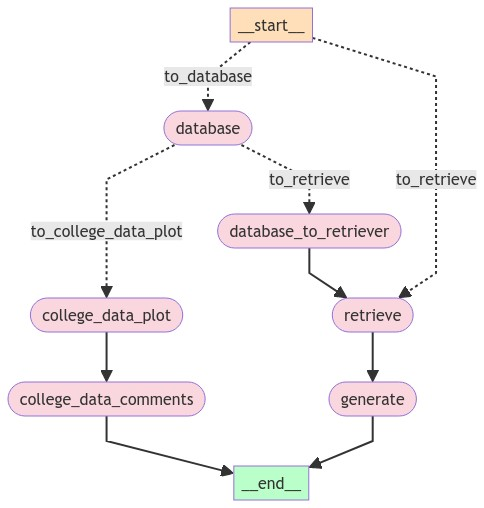

In [45]:
display(Image(app.get_graph().draw_mermaid_png(),width=600))
#png=app.get_graph().draw_mermaid_png()
#with open('GraphFlow.png','wb') as png:
#    png.write(png)

In [19]:
##################################docs embedding###########################

In [20]:
"""
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
import time
embeddings=OpenAIEmbeddings(model='text-embedding-3-small',chunk_size=20000)

kb=TXTKnowledgeBase(txt_source_folder_path='emergency')
docs=kb.load_txts()
#vector=kb.convert_documents_to_embeddings(docs)
vector=FAISS.from_documents([docs[0]],embeddings)
for i in range(1,len(docs)):
    vector.add_documents([docs[i]])
    time.sleep(1)
vector.save_local(
        folder_path='vector',
        index_name=('knowledge-base-vector-lxsq')
    )
"""

"\nfrom langchain_community.vectorstores import FAISS\nfrom langchain_openai import OpenAIEmbeddings\nimport time\nembeddings=OpenAIEmbeddings(model='text-embedding-3-small',chunk_size=20000)\n\nkb=TXTKnowledgeBase(txt_source_folder_path='emergency')\ndocs=kb.load_txts()\n#vector=kb.convert_documents_to_embeddings(docs)\nvector=FAISS.from_documents([docs[0]],embeddings)\nfor i in range(1,len(docs)):\n    vector.add_documents([docs[i]])\n    time.sleep(1)\nvector.save_local(\n        folder_path='vector',\n        index_name=('knowledge-base-vector-lxsq')\n    )\n"